In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [2]:
# 데이터 불러오기
file_path = 'D:/K1_nam4/인공지능개론/artificial-intelligence/AI_class/artificial-intelligence/week6/DataFame/car_evaluation.csv'

In [3]:
columns = ['buying', 'main', 'doors', 'persons', 'lug_boot', 'safety', 'output']

In [4]:
df = pd.read_csv(file_path, header=None, names=columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   main      1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   output    1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [5]:
df.head()

,buying,main,doors,persons,lug_boot,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [6]:
df.isnull().sum()

buying      0
main        0
doors       0
persons     0
lug_boot    0
safety      0
output      0
dtype: int64

In [7]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1723    False
1724    False
1725    False
1726    False
1727    False
Length: 1728, dtype: bool

<Axes: ylabel='count'>

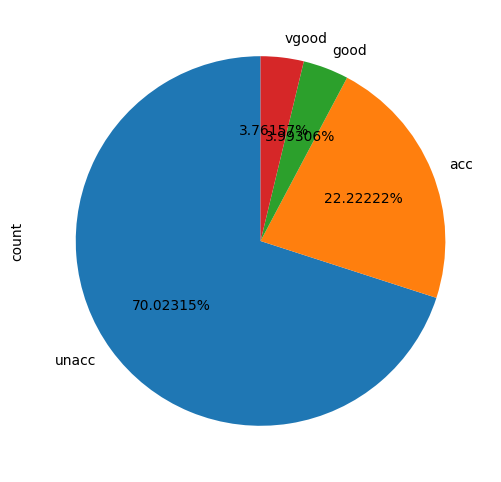

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
df.output.value_counts().plot(kind='pie', autopct='%0.05f%%', startangle=90, shadow=False)

In [9]:
 # label encoding
label_encoder = LabelEncoder()
for column in df.columns:
    df[column] = label_encoder.fit_transform(df[column])

In [10]:
df.head()

,buying,main,doors,persons,lug_boot,safety,output
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [11]:
df.nunique()

buying      4
main        4
doors       4
persons     3
lug_boot    3
safety      3
output      4
dtype: int64

In [12]:
# 데이터 분할
X = df.drop('output', axis=1).values
y = df['output'].values

# 데이터 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1382, 6), (1382,), (346, 6), (346,))

In [13]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [14]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([1382, 6]),
 torch.Size([1382]),
 torch.Size([346, 6]),
 torch.Size([346]))

# 모델 정의

In [16]:
class CarEvaluationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CarEvaluationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)    # input layer -> 64 neurons
        self.fc2 = nn.Linear(64, 32)            # hidden layer -> 32 neurons
        self.fc3 = nn.Linear(32, num_classes)   # output layer -> num_classes neurons (4 classes)
        self.relu = nn.ReLU()                   # ReLU activation function    (ham kich hoat ReLU dung sau fc1 va fc2)
        self.softmax = nn.Softmax(dim=1)        # 정의하지만 사용하지 않음 (softmax는 CrossEntropyLoss에 포함되어 있음)

    # forward function  (순전파)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model = CarEvaluationModel(input_size=6, num_classes=4)

# input vector 특성이 6개이고
# 모델이 4개의 클래스를 예측하는 모델을 정의


 - Softmax đã được định nghĩa nhưng không được dùng trong hàm forward. Điều này là bình thường nếu bạn sử dụng nn.CrossEntropyLoss trong quá trình huấn luyện, vì CrossEntropyLoss sẽ tự động áp dụng LogSoftmax cho bạn.
- softmax 정의 했지만 forward 에서 사용하지 않음 (softmax는 CrossEntropyLoss에 포함되어 있음). CrossEntropyLoss 자동으로 LogSoftmax 적용. 
 - Nếu bạn dùng mô hình này để dự đoán (inference) và muốn có xác suất thì nên thêm: 
- 만약에 inference 할 때 확률을 원하면:
```python
output = model(x)
probabilities = torch.softmax(output, dim=1)
```


In [17]:
# 손실 함수와 최적화기법
criterion = nn.CrossEntropyLoss()       # 다중 클래스 분류에서 사용되는 대표적인 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)        # Adam은 momentum + RMSprop의 장점을 결합한 최적화 기법

In [18]:
# 모델 학습
# 1. 모델을 학습하기 위한 손실 함수와 최적화 기법을 정의함.
train_losses = []               # 훈련 손실을 저장할 리스트 ( luu loss trung binh cua tung epoch khi train)
test_accuracies = []            # 테스트 정확도를 저장할 리스트 (luu accuracy - do chinh xac cua mo hinh tren tap test)

# 2. 모델을 학습하기
num_epochs = 100                # 훈련 epoch 수
# training loop
for epoch in range(num_epochs):     # 각각 epoch Train/Validation loop을 수행
    # train mode
    model.train()           # 모델을 훈련 모드로 설정
    running_loss = 0.0      # epoch 손실 초기화 ( dung de tich luy loss trong moi epoch)
    
    # minibatch loop 훈련
    for inputs, labels in train_loader:
        optimizer.zero_grad()           # zero the parameter gradients ( xoa gredient cu - vi PyTorch cong don theo mac dinh)
        outputs = model(inputs)       # forward pass ( du doan dau ra tu input)
        loss = criterion(outputs, labels)   # compute loss  ( tinh loss giua dau ra va nhan dung)
        loss.backward()         # backward pass  ( tinh gradient bang thuat toan backpropagation)
        optimizer.step()        # update weights ( cap nhat cac tham so - weights cua mo hinh)
        running_loss += loss.item() # accumulate loss ( luu loss cua batch vao total loss cua epoch)

    # Luu loss trung binh cua epoch
    train_losses.append(running_loss / len(train_loader))          # calculate average loss over an epoch ( tinh va luu loss trung binh tren tat ca mini-batch trong epoch)

    # validation loop
    model.eval()        # 모델을 평가 모드로 설정 ( chuyen sang che do danh gia - tat dropout, batchnorm dung trung binh)
    # correct, total dung de tinh do chinh xac
    correct = 0
    total = 0
    
    # Danh gia mo hinh khong dung gradient 
    with torch.no_grad():                               # gradient를 계산하지 않음 ( tat tinh toan gradient de tich kiem tai nguyen)
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)   # chon lop co xac suat cao nhat
            total += labels.size(0)                     # cong so luong mau
            correct += (predicted == labels).sum().item()   # dem so luong du doan dung

    # 정확수 계산하고 10 epoch마다 출력 ( tinh accuracy va in ra sau moi 10 epoch)
    test_accuracies.append(correct / total)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {correct / total:.4f}')

Epoch [10/100], Loss: 0.3353, Accuracy: 0.8121
Epoch [20/100], Loss: 0.1741, Accuracy: 0.9393
Epoch [30/100], Loss: 0.0917, Accuracy: 0.9422
Epoch [40/100], Loss: 0.0537, Accuracy: 0.9624
Epoch [50/100], Loss: 0.0357, Accuracy: 0.9711
Epoch [60/100], Loss: 0.0245, Accuracy: 0.9682
Epoch [70/100], Loss: 0.0168, Accuracy: 0.9798
Epoch [80/100], Loss: 0.0125, Accuracy: 0.9653
Epoch [90/100], Loss: 0.0090, Accuracy: 0.9769
Epoch [100/100], Loss: 0.0069, Accuracy: 0.9798


# 모델 요약


---

### ✅ 현재 코드 요약

####  학습 루프 (`model.train()`)
- 각 `batch`에 대해:
  - `forward` → `loss` 계산 → `backward` → `optimizer.step()` 수행
- `running_loss`를 누적해서 평균 epoch 손실 저장

#### ✅ 검증 루프 (`model.eval()`)
- `torch.no_grad()` 안에서 `forward`만 수행
- `accuracy` 측정 (예측과 실제 비교)
- `test_accuracies` 리스트에 저장

####  10 epoch마다 출력:
```python
Epoch [10/100], Loss: 0.4821, Accuracy: 0.8375
```

---

### 🔍 개선/확장 아이디어

1. **정확도와 손실 시각화 (matplotlib)**
   ```python
   import matplotlib.pyplot as plt

   plt.plot(train_losses, label='Train Loss')
   plt.plot(test_accuracies, label='Test Accuracy')
   plt.xlabel('Epoch')
   plt.legend()
   plt.title('Training Progress')
   plt.show()
   ```

2. **Early Stopping** 기능 추가 (성능 향상 정체 시 조기 중단)

3. **모델 저장 (최고 성능 기준)**
   ```python
   best_accuracy = 0.0
   for epoch in range(num_epochs):
       ...
       if correct / total > best_accuracy:
           best_accuracy = correct / total
           torch.save(model.state_dict(), 'best_model.pth')
   ```

4. **GPU 사용 최적화**
   - 장치 지정:
     ```python
     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     model.to(device)
     ```
   - 학습/검증 loop 내에서:
     ```python
     inputs, labels = inputs.to(device), labels.to(device)
     ```

---

필요하시면 다음도 도와드릴 수 있어요:
- `train_loader`, `test_loader` 정의 예시
- 학습이 느릴 경우 `tqdm`으로 progress bar 추가
- `Confusion Matrix`, `F1-score` 계산

혹시 지금 실행하고 있는 프로젝트가 자동차 평가(Car Evaluation) 관련이면, 추가로 데이터셋이나 전처리 방법도 도와드릴게요 :)

# 모델 평가

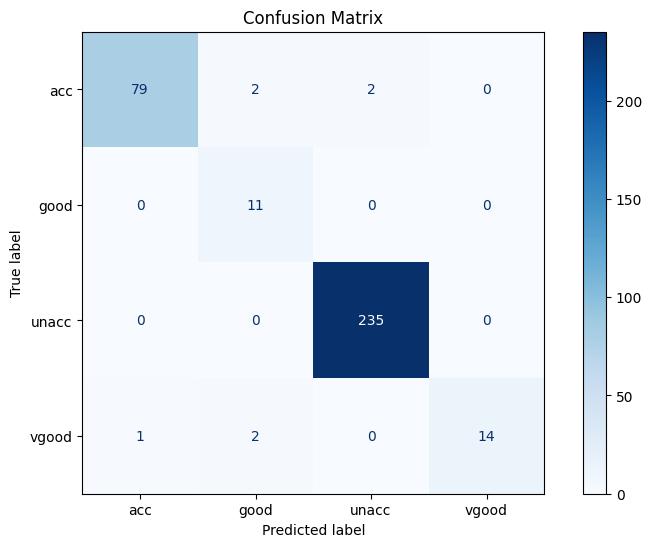

Precision: 0.9828
Recall: 0.9798
F1 Score: 0.9801


In [22]:
model.eval() # 평가 모드로 전환
all_labels = []
all_preds = []

# 데스이트 셋을 통해 예측
with torch.no_grad(): # gradient를 계산하지 않음 ( tat tinh toan gradient de tich kiem tai nguyen)
    for inputs, labels in test_loader:
        outputs = model(inputs)     # lay ket qua dau ra (logits) tu mo hinh
        _, predicted = torch.max(outputs.data, 1)   # tra ve chi so cua lop co gia tri cao nhat (tuc la lop duoc du doan)  
        # lưu nhãn thật và dự đoán vào list và chuyển sang numpy
        all_labels.extend(labels.numpy())   
        all_preds.extend(predicted.numpy())
        
# convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# calculate metrics - precision, recall, f1 score ( tinh cac chi so precision, recall, f1 score) danh gia mo hinh
precision = precision_score(all_labels, all_preds, average='weighted') # ty le du doan dung trong so cac du doan duong tinh
recall = recall_score(all_labels, all_preds, average='weighted') # ty le du doan dung trong so tat ca cac mau that su duong tinh
f1 = f1_score(all_labels, all_preds, average='weighted') # trung binh dieu hoa giua Precision va Recall
confusion = confusion_matrix(all_labels, all_preds) # ma tran so sanh giua du doan va thuc te (sai/le ch theo lop)
### average='weighted' : dam bao ket qua khong bi lech neu co lop xuat hien nhieu hon lop khac
# display confusion matrix
disp = ConfusionMatrixDisplay(confusion, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
# print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


---

##  Đánh giá mô hình sau huấn luyện

###  1. Chuyển sang chế độ đánh giá
```python
model.eval()
all_labels = []
all_preds = []
```
- `model.eval()`: tắt dropout, batchnorm... để đánh giá ổn định.
- `all_labels`, `all_preds`: lưu lại nhãn thật và nhãn dự đoán của tất cả mẫu trong tập test để tính chỉ số.

---

###  2. Duyệt qua tập test và dự đoán
```python
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())
```

| Thành phần | Giải thích |
|------------|------------|
| `torch.no_grad()` | Tắt việc tính toán gradient để tiết kiệm bộ nhớ và tăng tốc |
| `outputs = model(inputs)` | Lấy kết quả đầu ra (logits) từ mô hình |
| `torch.max(..., 1)` | Trả về chỉ số của lớp có giá trị cao nhất (tức là lớp được dự đoán) |
| `extend(...)` | Lưu nhãn thật và dự đoán vào list |

---

###  3. Chuyển list sang numpy array
```python
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
```
Giúp dễ dàng sử dụng với các hàm tính toán từ `sklearn`.

---

###  4. Tính các chỉ số đánh giá mô hình
```python
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
confusion = confusion_matrix(all_labels, all_preds)
```

| Chỉ số | Ý nghĩa |
|--------|--------|
| **Precision** | Tỷ lệ dự đoán đúng trong số các dự đoán dương tính |
| **Recall** | Tỷ lệ dự đoán đúng trong số tất cả các mẫu thật sự dương tính |
| **F1 Score** | Trung bình điều hòa giữa Precision và Recall |
| **Confusion matrix** | Ma trận so sánh giữa dự đoán và thực tế (sai/lệch theo lớp) |

 `average='weighted'`: đảm bảo kết quả không bị lệch nếu có lớp xuất hiện nhiều hơn lớp khác.

---

###  5. Vẽ Confusion Matrix
```python
disp = ConfusionMatrixDisplay(confusion, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
```
- `ConfusionMatrixDisplay`: công cụ trực quan hóa ma trận nhầm lẫn.
- `label_encoder.classes_`: tên của từng lớp (ví dụ: ['unacc', 'acc', 'good', 'vgood'])

---

###  6. In ra các chỉ số đánh giá
```python
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
```
- In kết quả chính xác đến 4 chữ số sau dấu thập phân.

---

##  Tóm lại
Bạn vừa:
- Đánh giá mô hình bằng cách duyệt qua toàn bộ tập test
- Tính **precision**, **recall**, **F1**, và **confusion matrix**
- Vẽ biểu đồ trực quan để nhìn thấy mô hình sai ở đâu

---



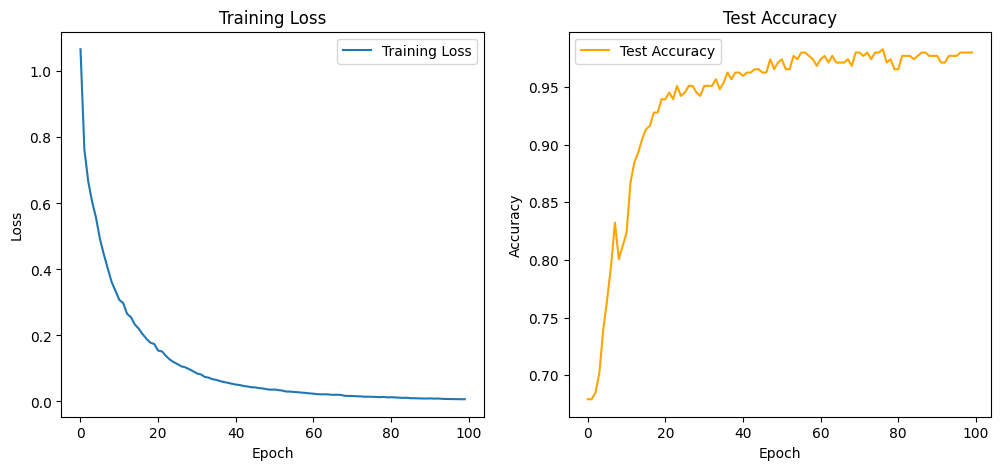

In [20]:
# plot training loss and test accuracy
plt.figure(figsize=(12, 5))

# plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()
